Create a one-to-one matching between the detection coordinate from drone footage and the formation coordinate from ground truth drill videos. For each frame, we use either matching (which only consider the current frame and disregard any previous matching results) or tracking (use the previous frame's matching results to help match the current frame, based on the idea that the same person's location in two consecutive frames wouldn't change much).

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import copy
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

### TODO


In [12]:
# Fill this in before matching for each video. All this video-specific information can be found in the synchrony table.
video_name = 'vid_14' 
formation_name = "JMI"
starting_frame = 5 * 60 # the starting frame of the formation video = staring second * frame rate ()
missing_members = [69, 85, 133, 143, 223, 239, 247, 260] # the members that are missing in the detection
formation_image_shape = (1430, 2726) # the shape of the WARPED formation image, can be found in preprocess_ground_truth.ipynb

# fill in the path
formation_folder = "/data/huanga/Synchrony/formation/" # where the ground truth formation is stored (assumed in numpy format)
formation_image_folder = "/data/huanga/Synchrony/formation_images" # the folder where the formation images are stored
box_frames_folder = "/data/huanga/Synchrony/box_frames" # the folder where the box frames and the corresponding coordinates were stored
warped_frames_folder = "/data/huanga/Synchrony/warped_frames" # the folder where the warped frames are stored
match_frames_folder = "/data/huanga/Synchrony/match_frames" # the folder where the matched frames will be stored
results_folder = "/data/huanga/Synchrony/results" # the folder where the results (matchings and diffs) will be stored

# create the output folder
os.makedirs(match_frames_folder, exist_ok=True)
os.makedirs(os.path.join(match_frames_folder, video_name), exist_ok=True)
os.makedirs(results_folder, exist_ok=True)
os.makedirs(os.path.join(results_folder, video_name), exist_ok=True)

# Load the ground truth formation
formation_coords = np.load(os.path.join(formation_folder, formation_name + "_warped.npy"), allow_pickle=True)
detection_coords = np.load(os.path.join(box_frames_folder, video_name, "coords.npy"), allow_pickle=True)
detection_frames = sorted(glob.glob(os.path.join(warped_frames_folder, video_name, "*.jpg")))
assert len(detection_coords) == len(detection_frames), "The number of frames and the number of coordinates do not match"

### Match on the first frame

#### Visualize groud truth coords (blue points) for the first frame

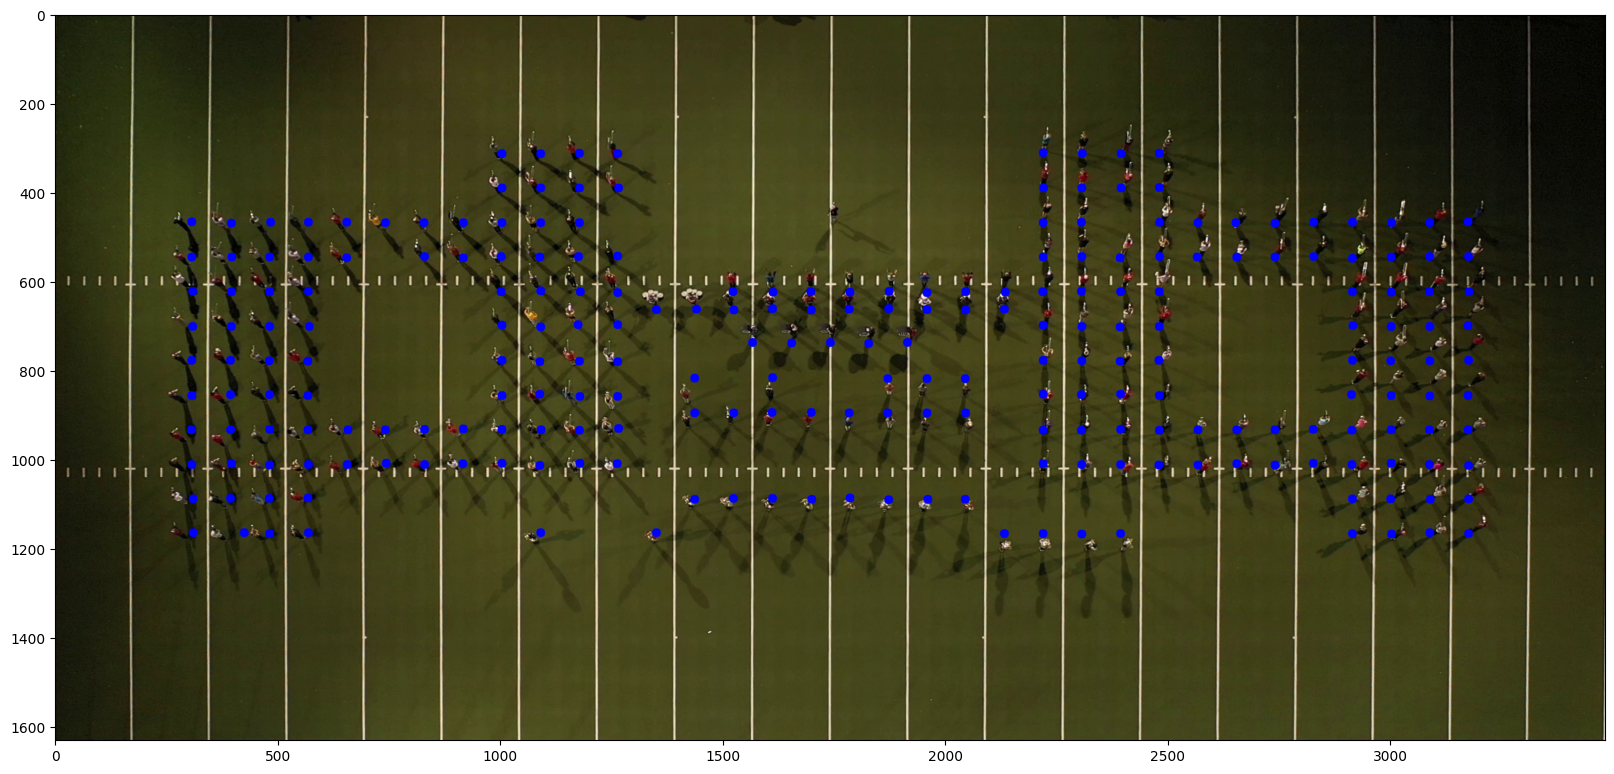

In [3]:
# sanity check on the first frame. simple matching between drone coords and formation coords
detection_frame_no = 0
formation_frame_no = starting_frame

# get the data for this frame
frame_detection_coords = detection_coords[detection_frame_no]
detection_image = cv2.imread(detection_frames[detection_frame_no])

# get the ratio between the football field in video footage and in ground truth 
x_ratio = detection_image.shape[1] / formation_image_shape[1]
y_ratio = detection_image.shape[0] / formation_image_shape[0]

# draw the coords of each member in ground truth to the video frame
blue_points = []
index_to_id = {}
radius = 10
for key, value in formation_coords[formation_frame_no].items():
    
    # if a member is not in drone footage, it will not be drawn from ground truth
    if key not in missing_members:
 
        index_to_id[len(blue_points)] = key
        blue_points.append((int(value[0] * x_ratio), int(value[1] * y_ratio)))
        cv2.circle(detection_image, (int(value[0] * x_ratio), int(value[1] * y_ratio)), radius, (255, 0, 0), -1)

plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(detection_image, cv2.COLOR_BGR2RGB))

#### Visualize detection coords (red points) for the first frame

The red points should be exactly on the band members!

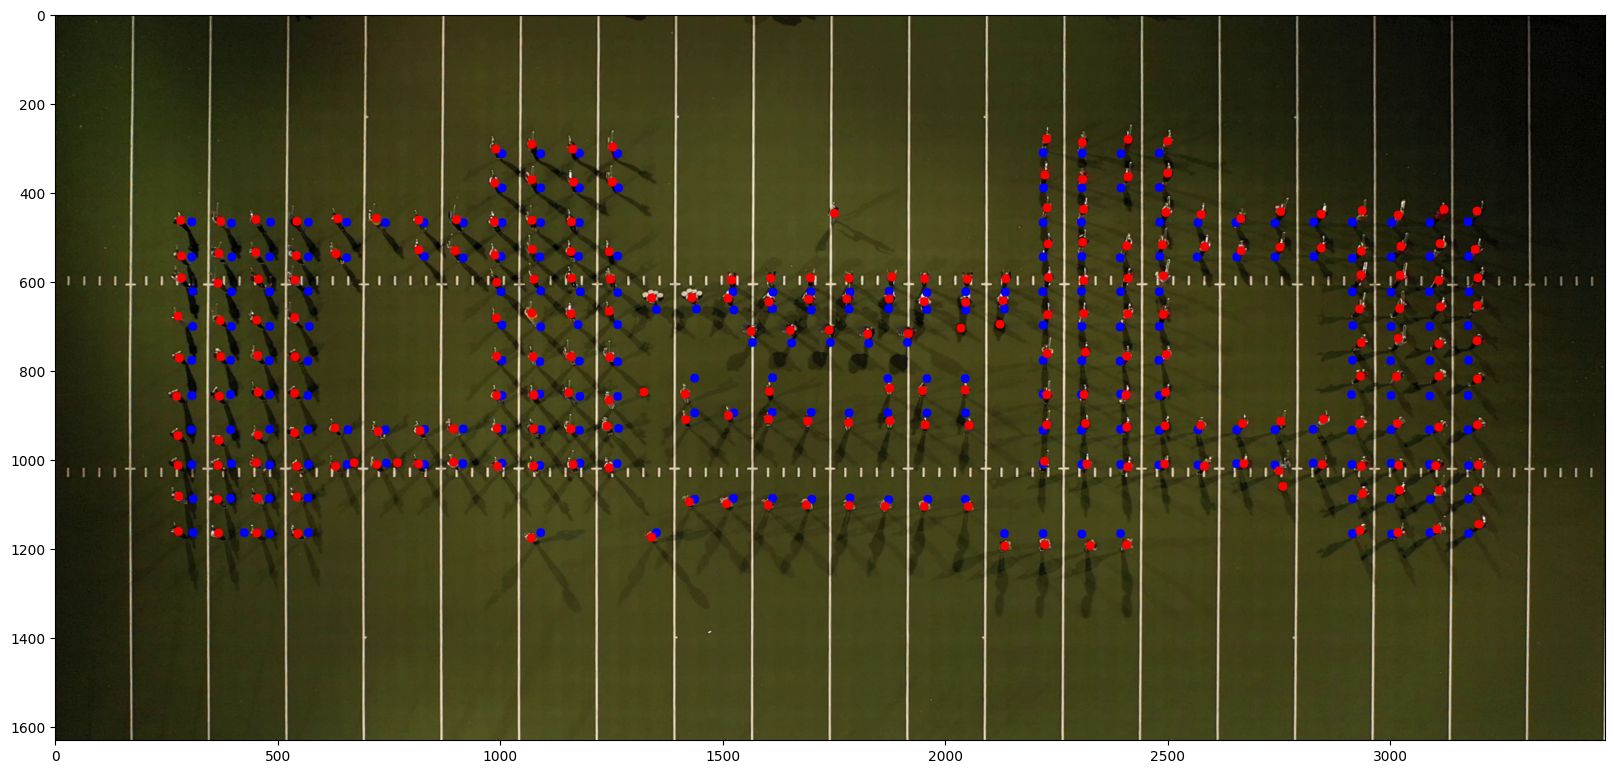

In [4]:
# draw the coords of each detected member in the drone footage
red_points = []
for point in frame_detection_coords:
    red_points.append((int(point[0]), int(point[1])))
    cv2.circle(detection_image, (int(point[0]), int(point[1])), radius, (0, 0, 255), -1)
    
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(detection_image, cv2.COLOR_BGR2RGB))

#### Visualize the matching for the first frame

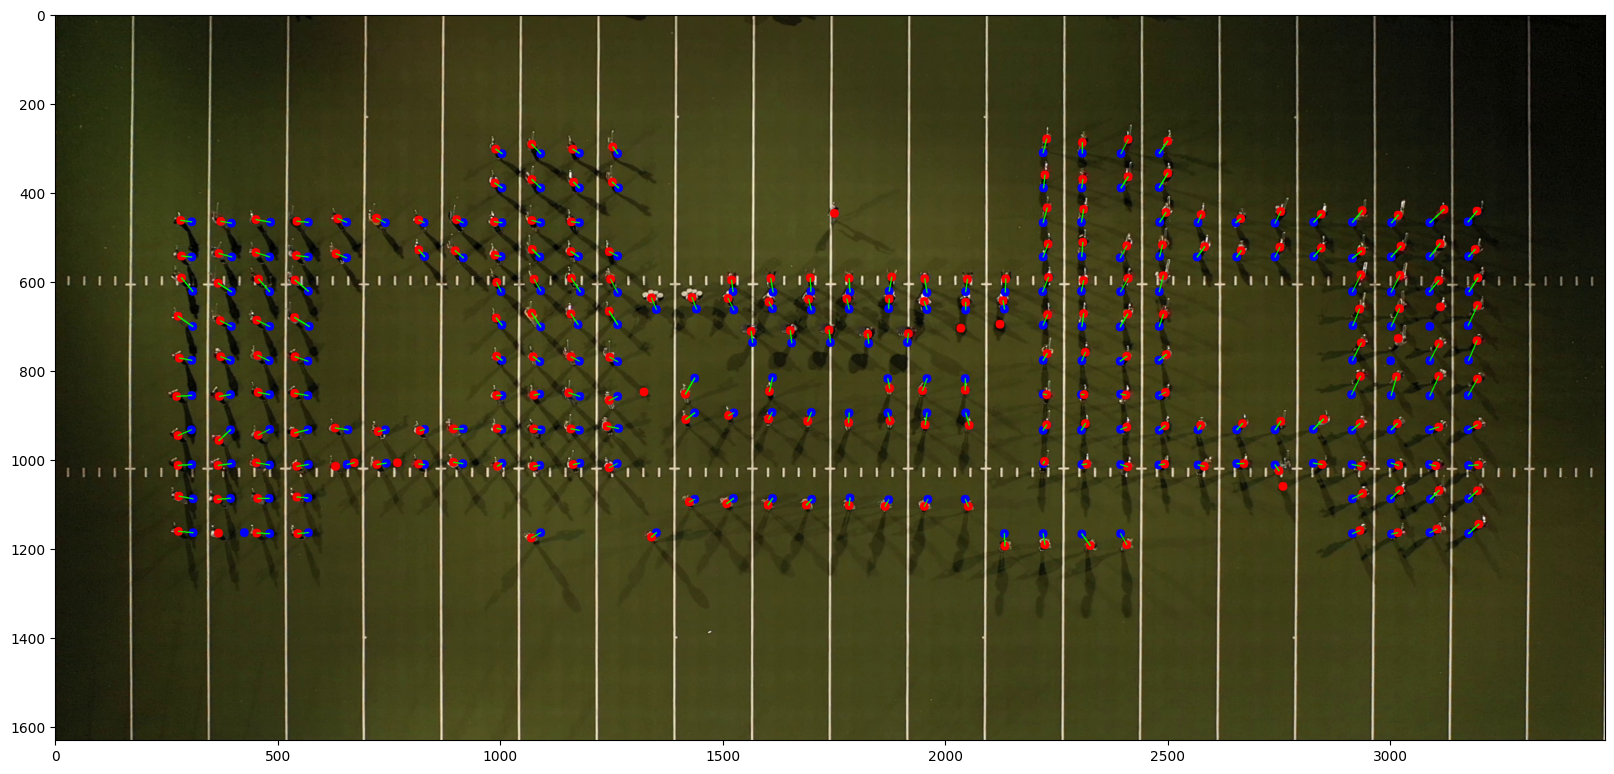

In [5]:
# TODO: Set the threshold for matching (the maximum distance between two points to be considered as a match)
threshold = 50 

# get the distance matrix
d = pairwise_distances(blue_points, red_points)
row_ind, col_ind = linear_sum_assignment(d)

# get the matches
matches = [] 
for i in range(len(row_ind)):
    if d[row_ind[i], col_ind[i]] < threshold:   
        matches.append((row_ind[i], col_ind[i]))
    else:
        matches.append(None)

# visualize the matches
temp_image = copy.deepcopy(detection_image)
for match in matches:
    if match != None:
        cv2.line(temp_image, blue_points[match[0]], red_points[match[1]], (0, 255, 0), 2)
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)) 

### Match the rest of the frames

In [6]:
"""
The utility functions for matching. For each frame, we can either match the points from scratch or use the previous frame's matching results to help match the current frame.
"""

def match_one_frame(formation_coords, detection_coords, detection_image, formation_image_shape, threshold, missing_members, radius=10):
    """
    Match the detected points to the ground truth points for one frame.
    Disregard any previous matching results and only consider the current frame.
    """
    
    red_points, blue_points, index_to_id = [], [], {}
    x_ratio = detection_image.shape[1] / formation_image_shape[1]
    y_ratio = detection_image.shape[0] / formation_image_shape[0]
    
    # Draw blue points
    for key, value in formation_coords.items():
        if key not in missing_members:
            index_to_id[len(blue_points)] = key
            blue_points.append((int(value[0] * x_ratio), int(value[1] * y_ratio)))
            cv2.circle(detection_image, (int(value[0] * x_ratio), int(value[1] * y_ratio)), radius, (255, 0, 0), -1)

    # Draw red points
    for point in detection_coords:
        red_points.append((point[0], point[1]))
        cv2.circle(detection_image, (int(point[0]), int(point[1])), radius, (0, 0, 255), -1)


    # get the distance matrix
    d = pairwise_distances(blue_points, red_points)
    row_ind, col_ind = linear_sum_assignment(d)


    # do the matching
    matches = [] 
    for i in range(len(row_ind)):
        if d[row_ind[i], col_ind[i]] < threshold:   
            matches.append((row_ind[i], col_ind[i]))
        else:
            matches.append(None)


    results_for_this_frame = {}
    for match in matches:
        if match != None:
            cv2.line(detection_image, blue_points[match[0]], red_points[match[1]], (0, 255, 0), 2)
            blue_index, red_index = match
            results_for_this_frame[index_to_id[blue_index]] = {
                "red_point": red_points[red_index],
                "blue_point": blue_points[blue_index],
                "red_blue_dist":  d[blue_index, red_index] / np.linalg.norm(detection_image.shape[:-1]),
            }
    return results_for_this_frame    


def track_one_frame(prev_frame_results, formation_coords, detection_coords, detection_image, red_red_threshold, red_blue_threshold, missing_members, radius=10):
    """
    match the detected points to the ground truth points for one frame.
    Use the previous frame's matching results to help match the current frame.
    
    red_red_threshold: the maximum distance between two red points in two consecutive frames to be considered the same point
    red_blue_threshold: the maximum distance between a red point and a blue point in the same frame to be considered a match
    """
    
    # Draw blue points
    for key, value in formation_coords.items():
        if key not in missing_members:
            cv2.circle(detection_image, (int(value[0] * x_ratio), int(value[1] * y_ratio)), radius, (255, 0, 0), -1)

    # Draw red points
    red_points = []
    for point in detection_coords:
        red_points.append((point[0], point[1]))
        cv2.circle(detection_image, (int(point[0]), int(point[1])), radius, (0, 0, 255), -1)


    # Get the red points from the previous frame  
    ids = []
    prev_red_points = []
    for key, value in prev_frame_results.items():
        ids.append(key)
        prev_red_points.append(value["red_point"])
    
    # Associate red points from this frame to the previous frame
    d = pairwise_distances(prev_red_points, red_points)
    row_ind, col_ind = linear_sum_assignment(d)
    results_for_this_frame = {}
    for i in range(len(row_ind)):
        
        # sanity check: if the red point is too far away from the previous red point, then don't match
        if d[row_ind[i], col_ind[i]] < red_red_threshold:   
            red_point = red_points[col_ind[i]]
            blue_point = (int(formation_coords[ids[row_ind[i]]][0] * x_ratio), int(formation_coords[ids[row_ind[i]]][1] * y_ratio))
            
            # sanity check: if the red point is too far away from the blue point, then don't match
            if np.linalg.norm(np.array(red_point) -  np.array(blue_point)) < red_blue_threshold:
                cv2.line(detection_image, blue_point, red_point, (0, 255, 0), 2)
                results_for_this_frame[ids[row_ind[i]]] = {
                    "red_point": red_point,
                    "blue_point":  blue_point,
                    "red_blue_dist":   np.linalg.norm(np.array(red_point) -  np.array(blue_point))/ np.linalg.norm(detection_image.shape[:-1]),
                }       
    return results_for_this_frame     

In [7]:
# TODO: Set the threshold for matching. The red_red_threshold should usually be set to the threshold used for matching the first frame.
red_red_threshold = 50 # the maximum distance between two red points in two consecutive frames to be considered the same point
red_blue_threshold = 200 # the maximum distance between a red point and a blue point in the same frame to be considered a match

# TODO: Set the frame index for using matching instead of tracking. Otherwise, the default behavior is to track.
# Note that we will always use matching for the first frame since we don't have previous frame's results.
rematch_time = [0,]
results_across_frames = []
for detection_frame_no in tqdm(range(len(detection_coords))):
    
    
    # get the data for this frame
    formation_frame_no = starting_frame + detection_frame_no * 2 # simple matching between dronev ideo and formation video. The *2 is because the formation video is 30fps and the drone video is 60fps
    frame_formation_coords = formation_coords[formation_frame_no]
    frame_detection_coords = detection_coords[detection_frame_no]
    detection_image = cv2.imread(detection_frames[detection_frame_no])
    
    
    # Use either matching or tracking for each frame
    if detection_frame_no in rematch_time:
        results_for_this_frame = match_one_frame(frame_formation_coords, frame_detection_coords, detection_image, formation_image_shape, threshold, missing_members, 10)
    else:
        results_for_this_frame = track_one_frame(prev_frame_results, frame_formation_coords, frame_detection_coords, detection_image, red_red_threshold, red_blue_threshold, missing_members, 10)
    
    
    # update the results
    prev_frame_results = results_for_this_frame
    results_across_frames.append(results_for_this_frame) 
    
    
    # NOTE: for writing frames to video, we need to pad the image to be even.
    # NOT important for the matching algorithm
    w, h, c = detection_image.shape
    pad_w = -1 if w % 2 == 1 else  None
    pad_h = -1 if h % 2 == 1 else  None
    
    
    # save the image
    cv2.imwrite(os.path.join(match_frames_folder, video_name, f"frame_{detection_frame_no + 1:04d}.jpg"), detection_image[:pad_w, :pad_h])

  0%|          | 1/539 [00:00<01:52,  4.80it/s]

100%|██████████| 539/539 [01:55<00:00,  4.67it/s]


## Save the matchings and the diffs

In [10]:
# TODO: Set the threshold for matching. If the same member across consecutive frames has a distance more than this threshold, then it is ignored and not counted as a succefssful match.
# The idea is that a member cannot travel too far in one frame.
diff_threshold = 50
diffs_across_frames = []

for i in range(len(results_across_frames)):
    
    if i == 0:
        continue
    
    prev = results_across_frames[i-1]
    current = results_across_frames[i]
    diffs = {}
    red_diffs = []
    blue_diffs = []
    for id in current.keys():
        if id in prev:
            red_diff = (np.array(prev[id]["red_point"]) - np.array(current[id]["red_point"]))
            blue_diff = (np.array(prev[id]["blue_point"]) - np.array(current[id]["blue_point"]))
            if  np.linalg.norm(red_diff) > diff_threshold:
                prev.pop(id)
            else:
                red_diffs.append(np.linalg.norm(red_diff))
                blue_diffs.append(np.linalg.norm(blue_diff))
                diffs[id] = {
                    "red_diff": red_diff,
                    "blue_diff": blue_diff,
                }
    print(f"frame: {i}, count: {len(red_diffs)}, max: {np.max(red_diffs)}, min: {np.min(red_diffs)}, mean: {np.mean(red_diffs)}") 
    diffs_across_frames.append(diffs)

frame: 1, count: 236, max: 21.633307652783937, min: 0.0, mean: 0.9712801444135439
frame: 2, count: 236, max: 21.633307652783937, min: 0.0, mean: 1.161350272747148
frame: 3, count: 236, max: 14.7648230602334, min: 0.0, mean: 0.9534833657813041
frame: 4, count: 236, max: 21.633307652783937, min: 0.0, mean: 1.15327172909095
frame: 5, count: 236, max: 41.0, min: 0.0, mean: 1.4448066256411576
frame: 6, count: 236, max: 15.231546211727817, min: 0.0, mean: 1.1765449891063127
frame: 7, count: 236, max: 15.231546211727817, min: 0.0, mean: 1.1490631749859181
frame: 8, count: 236, max: 20.248456731316587, min: 0.0, mean: 1.28419955305287
frame: 9, count: 236, max: 19.849433241279208, min: 0.0, mean: 1.266645984696253
frame: 10, count: 236, max: 20.248456731316587, min: 0.0, mean: 1.3827801235529131
frame: 11, count: 234, max: 21.400934559032695, min: 0.0, mean: 1.4503549181666342
frame: 12, count: 234, max: 19.1049731745428, min: 0.0, mean: 1.3053066331983356
frame: 13, count: 234, max: 17.720045

In [13]:
np.save(os.path.join(results_folder, video_name, "diffs.npy"), diffs_across_frames)
np.save(os.path.join(results_folder, video_name, "matchings.npy"), results_across_frames)